In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib as mplib
from matplotlib import pyplot as plt
import seaborn as sns
import pyro
import seaborn as sns

C:\Users\jakob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [150]:
# for each country and year change the life expectancy to the difference between life expectancy of this and the next year
import time
data = pd.read_csv("Data/Data_processed.csv", sep=';')


for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # transform data to look at differences from year to year for all nummerical features (2 first columns are country and continent)
    d.iloc[:,5:] = d.iloc[:,5:].diff()
    # replace invividual nan values with 0
    data[data['Country'] == country] = d

data['Life expectancy difference'] = 0
for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # get difference in life expectancy
    d['Life expectancy difference'] = d['Life expectancy '].diff()


    # replace old values with new values
    data[data['Country'] == country] = d

# remove year 2000
# data = data[data['Year'] != 2000]
# remove other data that contains nan values
# data = data.dropna()

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     2936 non-null   object 
 1   continent                   2936 non-null   object 
 2   Life expectancy             2936 non-null   float64
 3   Year                        2936 non-null   int64  
 4   Status                      2936 non-null   int64  
 5   infant deaths               2745 non-null   float64
 6   Alcohol                     2745 non-null   float64
 7   Hepatitis B                 2745 non-null   float64
 8   MeaslesPrMillion            2745 non-null   float64
 9   OverweightOfAdults%         2745 non-null   float64
 10  Polio                       2745 non-null   float64
 11  Total expenditure           2745 non-null   float64
 12  Diphtheria                  2745 non-null   float64
 13   HIV/AIDS                   2745 

In [151]:

# print(data.info())
# create a new column to store difference in life expectancy for 1, 2 and 3 years in the past
data['Life expectancy difference 1 year ago'] = 0
data['Life expectancy difference 2 years ago'] = 0
# get difference in life expectancy for each country and year
for country in data['Country'].unique():
    d = data[data['Country'] == country]
    # sort by year
    d = d.sort_values(by='Year')
    # get difference in life expectancy
    d['Life expectancy difference'] = d['Life expectancy difference'].shift(-1)
    d['Life expectancy difference 1 year ago'] = d['Life expectancy difference'].shift(1)
    d['Life expectancy difference 2 years ago'] = d['Life expectancy difference'].shift(2)

    # replace old values with new values
    data[data['Country'] == country] = d

# remove year 2001 and 2002
# data = data[data['Year'] != 2001]

# loop over each year and print how many nan values there are
# for year in data['Year'].unique():
#     print(year, data[data['Year'] == year].isna().sum().sum())

# print average over contries life expectancy difference for each year
data = data.dropna()
print(data.groupby('Year')['Life expectancy difference'].mean())



Year
2002    0.334970
2003    0.348231
2004    0.343238
2005    0.375969
2006    0.340868
2007    0.331219
2008    0.415480
2009    0.307339
2010    0.458009
2011    0.319320
2012    0.320209
2013    0.287139
2014    0.180493
Name: Life expectancy difference, dtype: float64


C:\Users\jakob\AppData\Local\Temp\ipykernel_8924\4255937255.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_split[col] = (train_split[col] - mean) / std
C:\Users\jakob\AppData\Local\Temp\ipykernel_8924\4255937255.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_split[col] = (test_split[col] - mean) / std


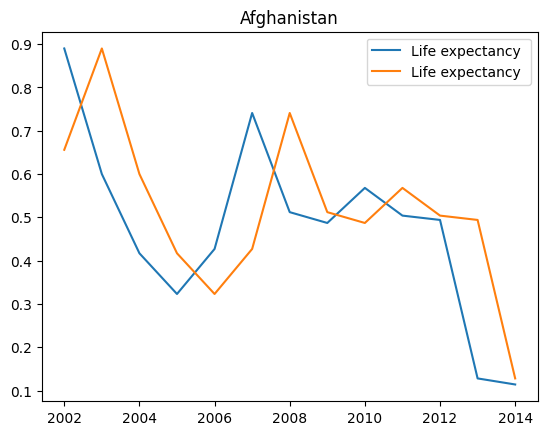

In [153]:
train_split = data[data['Year'] < 2009]
test_split = data[data['Year'] >= 2009]

# make list of all columns that need to be standardized
cols = train_split.columns
cols = cols.drop(['Country', 'continent', 'Year', 'Status'])
# standardize all columns except country, continent, year and status
for col in cols:
    if col not in ['Country', 'continent', 'Year', 'Status']:
        mean = train_split[col].mean()
        std = train_split[col].std()
        train_split[col] = (train_split[col] - mean) / std
        test_split[col] = (test_split[col] - mean) / std

# make new data without target variable
cols = cols.drop(['Life expectancy difference', 'Life expectancy '])


# plot life expectancy for each country
for i, country in enumerate(data['Country'].unique()):
    d = data[data['Country'] == country]
    plt.plot(d['Year'], d['Life expectancy difference'], label='Life expectancy ')
    plt.plot(d['Year'], d['Life expectancy difference 1 year ago'], label='Life expectancy ')
    plt.title(country)
    plt.legend()
    plt.show()
    if i == 0:
        break

In [154]:
# Fit linear model:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# fit a regression model to predict the difference in life expectancy
reg = LinearRegression().fit(train_split[cols], train_split['Life expectancy difference'])
# predict the difference in life expectancy for the test set
y_pred = reg.predict(test_split[cols])

# calculate the mean squared error
mse = mean_squared_error(test_split['Life expectancy difference'], y_pred)
print('Mean squared error: ', mse)

for i, col in enumerate(cols):
    print(col, reg.coef_[i])

# compare with baseline model that always predicts average of train data label
y_pred_baseline = np.ones(len(test_split)) * train_split['Life expectancy difference'].mean()
mse_baseline = mean_squared_error(test_split['Life expectancy difference'], y_pred_baseline)
print('Mean squared error baseline: ', mse_baseline)



Mean squared error:  2.074975779975844
infant deaths -0.2093278699305671
Alcohol 0.004041365209617256
Hepatitis B -0.009194633997962854
MeaslesPrMillion -0.019121158343471875
OverweightOfAdults% 0.04002436171876949
Polio 0.012912169261472128
Total expenditure 0.019597638647317065
Diphtheria  0.002728678000570391
 HIV/AIDS -0.21100397503512253
GDP 0.030943782857016343
Population 0.04602623353157656
 thinness  1-19 years 0.028884260108115647
Schooling -0.022592330164471906
WaterFacility 0.04929725661525034
WomenInParlament -0.015151934737000328
Life expectancy difference 1 year ago -0.1382835520703816
Life expectancy difference 2 years ago 0.13353548258672196
Mean squared error baseline:  2.1955322823340517


In [173]:
# fit ridge regression model
from sklearn.linear_model import Ridge
reg = Ridge(alpha=100).fit(train_split[cols], train_split['Life expectancy difference'])
# predict the difference in life expectancy for the test set
y_pred = reg.predict(test_split[cols])

# calculate the mean squared error
mse = mean_squared_error(test_split['Life expectancy difference'], y_pred)
print('Mean squared error: ', mse)

for i, col in enumerate(cols):
    print(col, reg.coef_[i])


Mean squared error:  2.0829416288156533
infant deaths -0.18181991443626147
Alcohol 0.004108867725278199
Hepatitis B -0.007684747579936944
MeaslesPrMillion -0.01867009519964346
OverweightOfAdults% 0.03707408450567632
Polio 0.012227003020969443
Total expenditure 0.017452499626830473
Diphtheria  0.0024662277829400744
 HIV/AIDS -0.19141139116746791
GDP 0.029527973196946278
Population 0.04634269095032267
 thinness  1-19 years 0.02811851114002452
Schooling -0.020323200860828883
WaterFacility 0.05356292400665752
WomenInParlament -0.012765915821733363
Life expectancy difference 1 year ago -0.1132523980754056
Life expectancy difference 2 years ago 0.13104534141606583


In [ ]:
# pyro linear dynamical system with inputs model (we assume that our other variables point to h, which then leads to life expectancy. 
# (Other variablies can be time dependent or not.) Here h would be like "life expectancy but without noise". Model is logical
# multi-variate state space model (we assume one hidden h eg. "Generel score" that leads to many observed variables. We don't necessarily
# assume that increasing the observed variable increases life expectancy. Model doesn't make as much sense as the one above.)
# different regimes? War vs not war? Pandemic vs not pandemic? Earthquake vs not earthquake? economic crisis vs not economic crisis? etc.
# probably better modelled with mixture model! Since so few "outlier" years where something like this happens. 
# output from h can flip a coin and then decide weight from maybe population or nothing!.

import torch
import pyro
import pyro.distributions as dist
